# General Practitioners in parisian departements

In [1]:
from pynsee.sirene import get_dimension_list, search_sirene
from pynsee.metadata import get_activity_list
from pynsee.geodata import get_geodata_list, get_geodata
from pynsee.localdata import get_geo_list

import difflib
import geopandas as gpd
import numpy
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import descartes
import re
from shapely.geometry import Polygon, MultiPolygon
from matplotlib.offsetbox import AnchoredText

In [2]:
import logging
import sys
logging.basicConfig(stream=sys.stdout,
                    level=logging.INFO, 
                    format="%(message)s")

In [4]:
get_dimension_list().to_csv("sirene_dimensions.csv")

Existing environment variables used, instead of locally saved credentials


1 - Getting data: 100%|██████████| 1/1 [00:00<00:00, 102.94it/s]

Data saved: /home/onyxia/.cache/pynsee/pynsee/76f10aaaadf5a625061805b71f0bf0db
This function renders package's internal data
This function may return personal data, please check and comply with the legal framework relating to personal data protection !


In [5]:
# get activity list
naf5 = get_activity_list('NAF5')
naf5.to_csv("naf.csv")
naf5[naf5["NAF5"].str.contains("^86.2")]

,A10,A129,A17,A21,A38,A5,A64,A88,NAF1,NAF2,NAF3,NAF4,NAF5,TITLE_NAF5_40CH_FR,TITLE_NAF5_65CH_FR,TITLE_NAF5_FR
664,OQ,Q86Z,OQ,Q,QA,OQ,QA0,86,Q,86,86.2,86.21,86.21Z,Activité des médecins généralistes,Activité des médecins généralistes,Activité des médecins généralistes
665,OQ,Q86Z,OQ,Q,QA,OQ,QA0,86,Q,86,86.2,86.22,86.22A,Act. radiodiagnostic et de radiothérapie,Activités de radiodiagnostic et de radiothérapie,Activités de radiodiagnostic et de radiothérapie
666,OQ,Q86Z,OQ,Q,QA,OQ,QA0,86,Q,86,86.2,86.22,86.22B,Activités chirurgicales,Activités chirurgicales,Activités chirurgicales
667,OQ,Q86Z,OQ,Q,QA,OQ,QA0,86,Q,86,86.2,86.22,86.22C,Autre activité des médecins spécialistes,Autres activités des médecins spécialistes,Autres activités des médecins spécialistes
668,OQ,Q86Z,OQ,Q,QA,OQ,QA0,86,Q,86,86.2,86.23,86.23Z,Pratique dentaire,Pratique dentaire,Pratique dentaire


In [6]:
# departements list of ile de france
list_dep = ["92", "93", "75", "94"] # + ["77", "78", "95", "91"]
string_dep = "|".join([dep + "*" for dep in list_dep])
string_dep

'92*|93*|75*|94*'

In [7]:
# search data on doctors

doctors = search_sirene(variable = ["activitePrincipaleEtablissement", "codePostalEtablissement"],
                        pattern = ['86.21Z*', string_dep],
                        number = 100000)
 # '86.21Z' médecin généraliste

doctors = doctors[doctors["activitePrincipaleEtablissement"].str.contains("^86.21Z")].reset_index(drop=True)

29/100 - Getting data: 100%|██████████| 175/175 [00:00<00:00, 255.57it/s]


Data saved: /home/onyxia/.cache/pynsee/pynsee/6c0f248de2346ddc6cb0d424b41d8f40


In [8]:
# filter
list_pattern = ["RADIOLOGIE", "IMAGERIE", "GYNECO", "DENTAIRE", "ANESTHES", 'P.M.I', 'INFANTILE', 'CARDIOLOG',
                "MAXILLO", "HOSPITALIER", "OPHTALMO", "DERMATOLOG", 'PLANIFICATION', 'MAIRIE', 'THORACIQUE',
                "TOMODENSITOM", "URGENCE", "NEPHROLOG", "PRAXEA", 'VACCINATION', 'SCOLAIRE', 'CANCER', 'STOMATOLO',
                "URODYNAMIQ", "CARDIORIS", "CHIRPLASTIQUE", "NINAMAX", "CICOF", 'MATERNELLE', 'DIALYSE',
                'RADIOTHERAPIE', 'RHUMATOLOG', 'DENTISTE', 'ECHOGRAPH', 'PATHOLOG', 'CHIRURGIE', 'ESTHETIQ',
                'CYTOLOG', 'ORTHOPED']

pattern = r"|".join(list_pattern)

In [9]:
# clean up the data not related to general practitioners but to other health activities
doctors = doctors[~doctors["denominationUniteLegale"].str.contains(pattern, regex=True, na=False)].reset_index(drop=True)
doctors = doctors[~doctors["enseigne1Etablissement"].str.contains(pattern, regex=True, na=False)].reset_index(drop=True)

# exclude association and administration
doctors = doctors[~doctors["categorieJuridiqueUniteLegale"].isin(["9220", "7220"])].reset_index(drop=True)
doctors = doctors.sort_values(["categorieJuridiqueUniteLegale"])

doctors.to_csv("doctors.csv")
list_denomination_uniteLegale = doctors.denominationUniteLegale.unique()

In [10]:
# get geographical data list
geodata_list = get_geodata_list()

# get communes geographical limits
com = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:commune')

# get arrondissement (subdivision of departement) geographical limits
arr = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:arrondissement')

Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/2ac583be54e866b2b1b30fb0113c1fd0
Set update=True to get the most up-to-date data


100%|██████████| 99/99 [00:33<00:00,  2.97it/s]


Data saved: /home/onyxia/.cache/pynsee/pynsee/a4f589755961ab3aa6bdff99605334d1
Data saved: /home/onyxia/.cache/pynsee/pynsee/1b27559c061e4bdaa0bd2966f4605287


In [11]:
# get arrondissement municipal geographical limits
arrmun = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:arrondissement_municipal')
arrmun = arrmun[arrmun.insee_com.str.contains('^75')].reset_index(drop=True)
arrmun["nom_m"] = arrmun["nom_m"].apply(lambda x: re.sub(r"ER|E", "", re.sub(" ARRONDISSEMENT", "", x)))
arrmun = arrmun.rename(columns={"geometry" : "geometry2",
                                "population" : "population2",
                               "nom_m" : "nom_m2"})
arrmun = arrmun[["nom_m2", "geometry2", "population2"]]

Data saved: /home/onyxia/.cache/pynsee/pynsee/94d0586636b45c9d8cdd466da4a3f3b8


In [12]:
def _replace_nan(x, y):
    if (x is None) or (numpy.isnan(x)):
        return y
    else:
        return x

In [13]:
doctors

,siren,nic,siret,dateDebut,dateCreationEtablissement,dateCreationUniteLegale,dateFin,denominationUniteLegale,nomUniteLegale,prenomUsuelUniteLegale,...,libellePaysEtrangerEtablissement,complementAdresse2Etablissement,indiceRepetition2Etablissement,libelleCommuneEtranger2Etablissement,distributionSpeciale2Etablissement,codeCedex2Etablissement,libelleCedex2Etablissement,codePaysEtranger2Etablissement,libellePaysEtranger2Etablissement,enseigne3Etablissement
5267,445161631,00038,44516163100038,2014-11-01,2014-11-01,2002-12-31,None,None,BACH,DANIEL,...,None,None,None,None,None,None,None,None,None,None
6477,518143185,00016,51814318500016,2009-11-02,2009-11-02,2009-11-02,None,None,RICCI,AXEL,...,None,None,None,None,None,None,None,None,None,None
6475,518032172,00026,51803217200026,2013-06-01,2013-06-01,2009-05-02,None,None,CHENIOUR,SOUMAYA,...,None,None,None,None,None,None,None,None,None,None
6474,518023916,00027,51802391600027,2012-01-02,2012-01-02,2009-10-31,None,None,BIBAS,AURORE,...,None,None,None,None,None,None,None,None,None,None
6473,518001169,00029,51800116900029,2015-12-02,2015-12-02,2009-06-05,None,None,SIDHOUM ANNAB,SAMIRA,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6916,775665805,00468,77566580500468,2008-01-01,1996-12-25,1900-01-01,None,COMPAGNIE FILLES CHARITE ST VINCENT PAUL,None,None,...,None,None,None,None,None,None,None,None,None,None
6928,775683006,00362,77568300600362,2017-06-21,2017-06-21,1900-01-01,None,FONDATION SANTE DES ETUDIANTS DE FRANCE,None,None,...,None,None,None,None,None,None,None,None,None,None
6915,775663883,00020,77566388300020,2008-01-01,1900-01-01,1900-01-01,None,INSTITUT ARTHUR VERNES,None,None,...,None,None,None,None,None,None,None,None,None,None
292,313711038,00015,31371103800015,2008-01-01,1978-01-01,1978-01-01,None,FONDATION HAHNEMANN,None,None,...,None,None,None,None,None,None,None,None,None,None


In [14]:
# count general practioners by commun
hdLegalStatus = doctors.groupby(['categorieJuridiqueUniteLegale'], dropna=True)['effectifsMinEtablissement'].agg(['mean', "count"])
   
hdLegalStatus["meanHeadcountLegalStatus"] = hdLegalStatus["mean"].apply(lambda x: _replace_nan(x, 1))

hdLegalStatus["categorieJuridiqueUniteLegale"] = hdLegalStatus.index
hdLegalStatus.loc[hdLegalStatus["categorieJuridiqueUniteLegale"] == "1000", "meanHeadcountLegalStatus"] = 1
hdLegalStatus = hdLegalStatus.reset_index(drop=True)

doctors = doctors.merge(hdLegalStatus, how = "left", on = "categorieJuridiqueUniteLegale").reset_index(drop=True)

for r in doctors.index:
    hdMin = doctors.loc[r, "effectifsMinEtablissement"]
    if (hdMin is None) or (numpy.isnan(hdMin)):
        doctors.loc[r, "headcount"] = doctors.loc[r, "meanHeadcountLegalStatus"]
    else:
        doctors.loc[r, "headcount"] = hdMin

In [15]:
# duplicates cleaning
# normalization to avoid double counting
doctors["headcountFinal"] = doctors["headcount"] / doctors.groupby("siren", dropna=True)["headcount"].transform("sum")

#visual check duplicates
dupDoctors = doctors[doctors["siren"].duplicated(keep=False)].reset_index(drop=True)
dupDoctors.to_csv("dupDoctors.csv")

list_adress_var = ["numeroVoieEtablissement", "typeVoieEtablissementLibelle", 
                   "libelleVoieEtablissement", "codePostalEtablissement", "libelleCommuneEtablissement"]

addressDupDoctors = doctors[doctors[list_adress_var].duplicated(keep=False)].reset_index(drop=True)
addressDupDoctors = addressDupDoctors.sort_values(list_adress_var)
addressDupDoctors.to_csv("addressDupDoctors.csv")

In [16]:
doctors.sort_values(["libelleCommuneEtablissement"]).to_csv("doctorSortedCom.csv")

In [17]:
# count general practioners by commune
doctorsCom = doctors.groupby(['libelleCommuneEtablissement', 'codePostalEtablissement'])['headcountFinal'].agg(['sum'])
doctorsCom = doctorsCom.rename(columns = {"sum" : "headcount"})
doctorsCom

,,headcount
libelleCommuneEtablissement,codePostalEtablissement,
ABLON-SUR-SEINE,94480,2.000000
ALFORTVILLE,94140,31.250000
ANTONY,92160,144.601926
ARCUEIL,94110,15.500000
ASNIERES-SUR-SEINE,92600,63.750000
...,...,...
VILLEPINTE,93420,24.000000
VILLETANEUSE,93430,4.000000
VILLIERS-SUR-MARNE,94350,15.000000


In [18]:
doctorsCom["libelleCommuneEtablissement"] = doctorsCom.index.get_level_values("libelleCommuneEtablissement")
doctorsCom["codePostalEtablissement"] = doctorsCom.index.get_level_values("codePostalEtablissement")
doctorsCom = doctorsCom.reset_index(drop=True)

In [19]:
import os, sys 

communes = get_geo_list("communes")

def _find_commune_identifier(com, dep, communes=communes):
    
    try:
        list_com = [c.upper() for c in communes.TITLE.to_list()]    
        communes["TITLE"] = list_com    
        communes = communes[communes["CODE_DEP"] == dep].reset_index(drop=True)

        match = difflib.get_close_matches(com.upper(), list_com)[0]

        cog = communes[communes["TITLE"] == match].reset_index(drop=True)
        cog = cog.loc[0, "CODE"]
    except:
        cog = None
    
    return cog      
  
for r in doctorsCom.index:
    dep = doctorsCom.loc[r, "codePostalEtablissement"][:2]
    comName = doctorsCom.loc[r, "libelleCommuneEtablissement"]
    doctorsCom.loc[r, "insee_com"] = _find_commune_identifier(comName, dep)

In [20]:
comDep = com[com["insee_dep" ].isin(list_dep)].reset_index(drop=True)
doctorsCom2 = comDep.merge(doctorsCom, how = "left", on = "insee_com")

In [21]:
doctorsCom2["headcount"] = doctorsCom2["headcount"].apply(lambda x: _replace_nan(x, 0))

In [22]:
doctorsCom2["headcount"] = doctorsCom2["headcount"].apply(lambda x: _replace_nan(x, 0))
doctorsCom2["ratio"] = 1000 * doctorsCom2["headcount"] / doctorsCom2["population"]

In [23]:
doctorsCom2 = doctorsCom2.reset_index(drop=True)

doctorsCom4 = doctorsCom2[doctorsCom2.columns].merge(arrmun, left_on ="libelleCommuneEtablissement", right_on="nom_m2", how="left")
for i in doctorsCom4.index:
    if type(doctorsCom4.loc[i, 'geometry2']) in [MultiPolygon, Polygon]:
        doctorsCom4.loc[i, 'geometry'] = doctorsCom4.loc[i, 'geometry2']
        doctorsCom4.loc[i, "ratio"] = 1000 * doctorsCom4.loc[i,"headcount"] / doctorsCom4.loc[i,"population2"]

del doctorsCom4["geometry2"]
doctorsCom2Map = gpd.GeoDataFrame(doctorsCom4)

In [24]:
doctorsCom2Map = gpd.GeoDataFrame(doctorsCom4)

In [25]:
# compute density ranges of GP
doctorsCom2Map.loc[doctorsCom2Map.ratio < 1, 'range'] = "< 0.2"
doctorsCom2Map.loc[doctorsCom2Map.ratio >= 5, 'range'] = "> 5"

density_ranges = [0.2, 0.6, 1, 1.5, 2, 2.5, 3, 3.5, 5]
list_ranges = []
list_ranges.append( "< 0.2")

for i in range(len(density_ranges)-1):
    min_range = density_ranges[i]
    max_range = density_ranges[i+1]
    range_string = "[{}, {}[".format(min_range, max_range)
    rows = (doctorsCom2Map.ratio >= min_range) & (doctorsCom2Map.ratio < max_range)
    doctorsCom2Map.loc[rows, 'range'] = range_string
    list_ranges.append(range_string)

list_ranges.append("> 5")

doctorsCom2Map['range2'] = doctorsCom2Map['range'].astype(CategoricalDtype(categories=list_ranges, ordered=True))

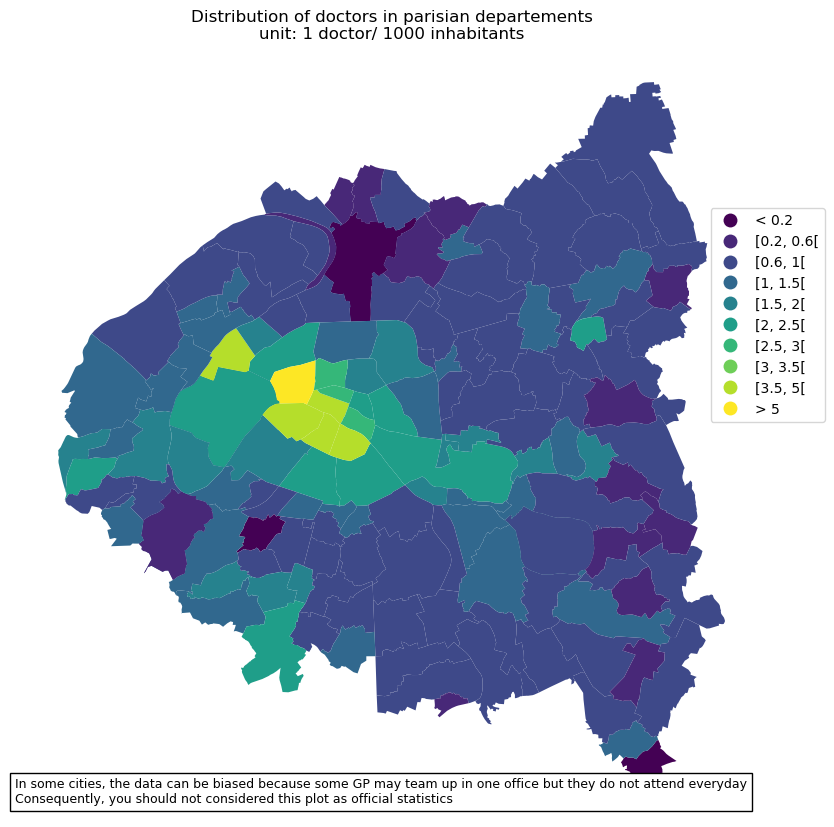

In [26]:
# make plot
txt = 'In some cities, the data can be biased because some GP may team up in one office but they do not attend everyday'
txt += '\nConsequently, you should not considered this plot as official statistics'

fig, ax = plt.subplots(1,1,figsize=[10,10])
doctorsCom2Map.plot(column='range2', cmap=cm.viridis,
    legend=True, ax=ax, 
    legend_kwds={'bbox_to_anchor': (1.1, 0.8)})
ax.set_axis_off()
ax.set(title='Distribution of doctors in parisian departements\nunit: 1 doctor/ 1000 inhabitants')
at = AnchoredText(txt, prop=dict(size=9), frameon=True, loc=4)
ax.add_artist(at)
plt.show()